In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import numba
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (18, 5)
pd.set_option('display.max_rows', 5)

Populating the interactive namespace from numpy and matplotlib


## GET DATA

In [2]:
charges = pd.read_csv('./inputs/Задание_3/Charges.csv', parse_dates=['BILL_MONTH'])
charges.columns.name = 'charges'
charges.drop_duplicates(inplace=True)
display(charges)
print('unique subscribers #:', len(charges['SUBSCRIBER_ID'].unique()))
print('period:', charges['BILL_MONTH'].min(), '..', charges['BILL_MONTH'].max())

charges,SUBSCRIBER_ID,BILL_MONTH,CHARGES
0,4741,2017-03-01,4.572
1,1754,2017-05-01,4.894
...,...,...,...
112593,4747,2017-06-01,5.182
112594,4992,2017-09-01,6.424


unique subscribers #: 5989
period: 2016-06-01 00:00:00 .. 2017-12-01 00:00:00


In [3]:
dttm_parser = lambda x: pd.NaT if x == '$null$' else pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

plan_changes = pd.read_csv('./inputs/Задание_3/Tariff_plans_change.csv',
                           parse_dates=['START_DTTM', 'END_DTTM'], date_parser=dttm_parser)
plan_changes.columns.name = 'plan_changes'
plan_changes.drop_duplicates(inplace=True)
display(plan_changes)

g = plan_changes.groupby(by='SUBSCRIBER_ID').aggregate(len)
print('subscribers never changed plans #:', len(g[g['TARIFF_PLAN_ID'] < 2]))
print('subscribers had 2 plans #:', len(g[g['TARIFF_PLAN_ID'] == 2]))
print('subscribers had 3 plans #:', len(g[g['TARIFF_PLAN_ID'] == 3]))
print('subscribers had 4 plans #:', len(g[g['TARIFF_PLAN_ID'] == 4]))
print('subscribers had > 4 plans #:', len(g[g['TARIFF_PLAN_ID'] > 4]))

print('unique plans:', plan_changes['TARIFF_PLAN_ID'].unique())
print('unique subscribers #:', len(plan_changes['SUBSCRIBER_ID'].unique()))
print('active subscribers #:', pd.isnull(plan_changes['END_DTTM']).sum())
print('period:', plan_changes['START_DTTM'].min(), '..', plan_changes['END_DTTM'].max())

plan_changes,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM
0,1,2,2013-11-22 21:10:08,2017-03-11 14:24:17
1,1,3,2017-03-11 14:24:18,NaT
...,...,...,...,...
12342,5989,5,2017-05-24 14:46:11,2017-05-25 20:12:32
12343,5989,1,2017-05-25 20:12:33,NaT


subscribers never changed plans #: 0
subscribers had 2 plans #: 5718
subscribers had 3 plans #: 245
subscribers had 4 plans #: 21
subscribers had > 4 plans #: 5
unique plans: [2 3 1 5 4]
unique subscribers #: 5989
active subscribers #: 5923
period: 1999-07-12 12:55:54 .. 2018-01-19 17:51:56


In [4]:
dt_parser = lambda x: pd.NaT if x == '$null$' else pd.datetime.strptime(x, '%Y-%m-%d')

suspensions = pd.read_csv('./inputs/Задание_3/Suspended.csv', 
                          parse_dates=['START_DT', 'END_DT'], date_parser=dt_parser)
suspensions.columns.name = 'suspensions'
suspensions.drop_duplicates(inplace=True)
suspensions['duration'] = suspensions['END_DT'] - suspensions['START_DT']
suspensions.sort_values(by=['SUBSCRIBER_ID', 'START_DT'], inplace=True)
display(suspensions)
print('unique subscribers #:', len(suspensions['SUBSCRIBER_ID'].unique()))
print('suspended subscribers #:', pd.isnull(suspensions['END_DT']).sum())
print('period:', suspensions['START_DT'].min(), '..', suspensions['END_DT'].max())
print('status other than suspended rows #:', (suspensions['STATUS'] != 'Suspended').sum())

suspensions,SUBSCRIBER_ID,START_DT,END_DT,STATUS,duration
2961,5,2016-07-25,2016-08-14,Suspended,20 days
2914,5,2016-09-19,2016-09-28,Suspended,9 days
...,...,...,...,...,...
3342,5988,2017-09-08,2017-09-08,Suspended,0 days
3309,5988,2017-09-25,2017-10-08,Suspended,13 days


unique subscribers #: 1310
suspended subscribers #: 66
period: 2016-06-01 00:00:00 .. 2018-01-17 00:00:00
status other than suspended rows #: 0


In [5]:
charges_pivoted = charges.pivot(columns='BILL_MONTH', values='CHARGES', index='SUBSCRIBER_ID')
display(charges_pivoted)

BILL_MONTH,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00,2016-09-01 00:00:00,2016-10-01 00:00:00,2016-11-01 00:00:00,2016-12-01 00:00:00,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00
SUBSCRIBER_ID,,,,,,,,,,,,,,,,,,,
1,21.137,32.545,30.042,24.964,27.628,22.374,21.132,20.268,27.858,27.660,23.983,27.487,23.651,28.552,32.074,24.012,20.464,19.296,16.062
2,4.756,5.868,5.876,4.853,5.237,6.946,5.750,5.327,5.092,5.467,5.440,5.868,5.675,5.044,5.368,4.984,5.292,4.964,4.964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.667,11.506,8.632,8.516,4.884,6.589,0.000,0.000
5989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.294,5.068,5.016,5.122,6.068,5.752,5.088,5.226


mean monthly bill stays pretty much the same, no reason to complicate things by considering trend


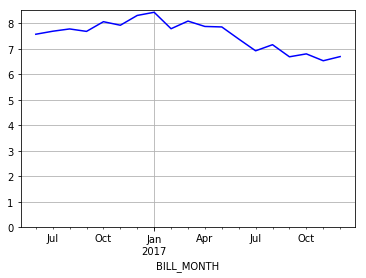

In [6]:
mean_charges_per_month = charges_pivoted.mean(axis=0)
mean_charges_per_month.plot(ylim=(0, None), color='blue', grid=True)
print('mean monthly bill stays pretty much the same, no reason to complicate things by considering trend')

In [7]:
charges_per_subscriber = charges_pivoted.sum(axis=1)
display(charges_per_subscriber)

SUBSCRIBER_ID
1       471.189
2       102.771
         ...   
5988     59.794
5989     38.634
Length: 5989, dtype: float64

# I PLANS MIGRATIONS

In [8]:
plans = plan_changes.copy()

# should have used some dataframe shift trick here
@numba.jit
def find_prev_plans(plan_changes):
    p = plan_changes
    p.sort_values(by=['SUBSCRIBER_ID', 'START_DTTM'], inplace=True)
    p['duration'] = p['END_DTTM'] - p['START_DTTM']
    p['prev_plan_row'] = pd.Series(-1, index=p.index, dtype=p.index.dtype)
    p['prev_plan'] = pd.Series(index=p.index, dtype=p['TARIFF_PLAN_ID'].dtype)
    p['prev_duration'] = pd.Series(pd.NaT, index=p.index, dtype=p['duration'].dtype)
    p['no_plan_duration'] = pd.Series(pd.NaT, index=p.index, dtype=p['duration'].dtype)
    
    prev_subs = None
    prev_plan = -1
    prev_dur = pd.NaT
    prev_end = pd.NaT
    for i in p.index:
        row = p.loc[i]
        subs, plan, dur, start, end = row[['SUBSCRIBER_ID', 'TARIFF_PLAN_ID', 'duration', 'START_DTTM', 'END_DTTM']]
        if subs != prev_subs: 
            prev_subs = subs
            prev_plan_row = -1
            prev_plan = -1
            prev_dur = pd.NaT
            prev_end = pd.NaT
        p.at[i, 'prev_plan_row'] = prev_plan_row
        p.at[i, 'prev_plan'] = prev_plan
        p.at[i, 'prev_duration'] = prev_dur
        p.at[i, 'no_plan_duration'] = start - prev_end
        prev_plan_row = i
        prev_plan = plan
        prev_dur = dur
        prev_end = end


find_prev_plans(plans)
with pd.option_context('display.max_rows', 5):
    display(plans.iloc[:])
    print(plans['no_plan_duration'].describe())

plan_changes,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM,duration,prev_plan_row,prev_plan,prev_duration,no_plan_duration
0,1,2,2013-11-22 21:10:08,2017-03-11 14:24:17,1204 days 17:14:09,-1,-1,NaT,NaT
1,1,3,2017-03-11 14:24:18,NaT,NaT,0,2,1204 days 17:14:09,00:00:01
...,...,...,...,...,...,...,...,...,...
12342,5989,5,2017-05-24 14:46:11,2017-05-25 20:12:32,1 days 05:26:21,-1,-1,NaT,NaT
12343,5989,1,2017-05-25 20:12:33,NaT,NaT,12342,5,1 days 05:26:21,00:00:01


count                      6298
mean     0 days 02:18:18.355986
                  ...          
75%             0 days 00:00:01
max           135 days 19:48:11
Name: no_plan_duration, Length: 8, dtype: object


In [9]:
# not sure if a change after a long delay should still be considered a change
no_plan_long_duration = pd.Timedelta(30, 'D')
long_plans = plans['no_plan_duration'] > no_plan_long_duration
same_plans = plans['TARIFF_PLAN_ID'] == plans['prev_plan'] # easier to drop than stitch together
plans_to_drop = plans[long_plans | same_plans]
ps = plans.drop(index=plans_to_drop.index)

with pd.option_context('display.max_rows', 10):
    print('dropped plans #:', len(plans_to_drop))
    print('plans after dropping #:', len(ps))
    print('same plans #:', len(same_plans))
    display(plans_to_drop)

dropped plans #: 13
plans after dropping #: 12274
same plans #: 12287


plan_changes,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM,duration,prev_plan_row,prev_plan,prev_duration,no_plan_duration
92,46,3,2017-02-02 14:24:13,2017-04-13 18:07:58,70 days 03:43:45,91,3,2411 days 05:57:01,1 days 21:57:53
289,140,5,2017-05-21 12:07:46,NaT,NaT,288,5,55 days 16:05:48,1 days 23:30:16
387,187,4,2017-05-23 21:18:55,2017-06-09 13:38:02,16 days 16:19:07,386,5,38 days 06:33:22,103 days 02:24:03
983,475,3,2017-06-01 10:27:43,NaT,NaT,982,5,11 days 05:47:20,135 days 19:48:11
2486,1209,5,2017-04-01 12:02:41,NaT,NaT,2485,5,29 days 21:34:33,30 days 23:38:40
...,...,...,...,...,...,...,...,...,...
9077,4420,5,2017-04-01 15:27:13,NaT,NaT,9076,5,7 days 15:34:46,29 days 00:35:11
9466,4608,1,2017-05-11 16:09:07,2017-06-02 17:07:39,22 days 00:58:32,9465,3,382 days 21:59:25,55 days 07:36:31
11496,5591,4,2017-01-02 11:39:43,2017-05-26 09:56:11,143 days 22:16:28,11495,4,265 days 22:00:36,0 days 01:22:43
11576,5630,3,2017-04-01 21:49:58,NaT,NaT,11575,3,19 days 18:40:34,45 days 07:12:51


In [10]:
def dur_aggfunc(series):
    return np.sum(series) #if series.count() else pd.NaT

plans_pivoted = ps.pivot_table(columns='TARIFF_PLAN_ID', index='SUBSCRIBER_ID', values='duration',
                                  aggfunc=dur_aggfunc)
with pd.option_context('display.max_rows', 10):
    display(plans_pivoted)

TARIFF_PLAN_ID,1,2,3,4,5
SUBSCRIBER_ID,,,,,
1,NaT,1204 days 17:14:09,0 days 00:00:00,NaT,NaT
2,509 days 20:03:24,NaT,NaT,NaT,0 days 00:00:00
3,708 days 16:43:13,NaT,NaT,NaT,0 days 00:00:00
4,NaT,NaT,347 days 20:23:59,NaT,0 days 00:00:00
5,457 days 04:32:44,NaT,NaT,NaT,0 days 00:00:00
...,...,...,...,...,...
5985,NaT,NaT,NaT,64 days 00:59:13,0 days 00:00:00
5986,0 days 00:00:00,NaT,NaT,NaT,57 days 06:16:30
5987,NaT,NaT,0 days 00:00:00,NaT,14 days 19:40:35


In [11]:
migrations = ps.pivot_table(index='prev_plan', columns='TARIFF_PLAN_ID', values='duration', aggfunc=len)

migrations.rename(columns=lambda col: 'to ' + str(col), inplace=True)
migrations.rename(index=lambda row: 'from ' + str(row) if row != -1 else 'no plan', inplace=True)
with pd.option_context('display.max_rows', 10):
    print('total migrations #', len(ps))
    display(migrations)
print(migrations.to_json(orient='columns'))
migrations.to_json('outputs/migrations.json')

total migrations # 12274


TARIFF_PLAN_ID,to 1,to 2,to 3,to 4,to 5
prev_plan,,,,,
no plan,2021.0,604.0,2745.0,528.0,91.0
from 1,NaN,5.0,55.0,378.0,1613.0
from 2,13.0,NaN,20.0,158.0,417.0
from 3,27.0,12.0,NaN,367.0,2372.0
from 4,37.0,20.0,56.0,NaN,528.0
from 5,81.0,4.0,74.0,48.0,NaN


{"to 1":{"no plan":2021.0,"from 1":null,"from 2":13.0,"from 3":27.0,"from 4":37.0,"from 5":81.0},"to 2":{"no plan":604.0,"from 1":5.0,"from 2":null,"from 3":12.0,"from 4":20.0,"from 5":4.0},"to 3":{"no plan":2745.0,"from 1":55.0,"from 2":20.0,"from 3":null,"from 4":56.0,"from 5":74.0},"to 4":{"no plan":528.0,"from 1":378.0,"from 2":158.0,"from 3":367.0,"from 4":null,"from 5":48.0},"to 5":{"no plan":91.0,"from 1":1613.0,"from 2":417.0,"from 3":2372.0,"from 4":528.0,"from 5":null}}


In [12]:
display(HTML(filename='migrations-flow/dist/index.html'))
# display(Image(filename='outputs/migrations-all-time.png'))

# II CHARGES

In [13]:
chs = charges.sort_values(by=['SUBSCRIBER_ID', 'BILL_MONTH']).set_index(['SUBSCRIBER_ID'])

with pd.option_context('display.max_rows', 14):
    display(chs.head(25))

charges,BILL_MONTH,CHARGES
SUBSCRIBER_ID,,
1,2016-06-01,21.137
1,2016-07-01,32.545
1,2016-08-01,30.042
1,2016-09-01,24.964
1,2016-10-01,27.628
1,2016-11-01,22.374
1,2016-12-01,21.132
...,...,...
1,2017-12-01,16.062


In [14]:
from pandas.tseries.offsets import MonthBegin, MonthEnd

plans_with_charges = ps.iloc[:].copy()
plans_max_end = plans_with_charges['END_DTTM'].max()
plans_with_charges.loc[pd.isnull(plans_with_charges['END_DTTM']), 'END_DTTM'] = plans_max_end
plans_with_charges['START_DTTM'] = (plans_with_charges['START_DTTM'] + MonthBegin(1)).dt.floor('D')
plans_with_charges['END_DTTM'] = (plans_with_charges['END_DTTM'] + MonthBegin(-1)).dt.floor('D')

# @numba.jit
def calc_charges_per_plan(plans, charges):
    periods = 3
    plans['charged'] = pd.Series(index=plans.index, dtype=charges['CHARGES'].dtype)
    plans['ch_beg3'] = pd.Series(index=plans.index, dtype=charges['CHARGES'].dtype)
    plans['ch_end3'] = pd.Series(index=plans.index, dtype=charges['CHARGES'].dtype)
    plans['full_months_with_charging_info'] = pd.Series(index=plans.index, dtype=int)
    for row in plans.itertuples():
        index, subs, plan, start, end, *_ = row
        all_chs = charges.loc[subs]
        chs = all_chs[(all_chs['BILL_MONTH'] >= start) & (all_chs['BILL_MONTH'] < end)]
        end3_start = end + MonthBegin(-periods)
        beg3_end = start + MonthBegin(periods)
        ch_beg3 = chs[chs['BILL_MONTH'] < beg3_end]
        ch_end3 = chs[chs['BILL_MONTH'] >= end3_start]
#         print('xxx', subs, plan, start, beg3_end, end3_start, end, len(ch_beg3), len(ch_end3), len(chs))  
#         display(all_chs)
#         display(chs)
#         display(ch_beg3)
#         display(ch_end3)
        plans.at[index, 'full_months_with_charging_info'] = len(chs)
        plans.at[index, 'charged'] = chs['CHARGES'].sum()
        plans.at[index, 'ch_beg3'] = ch_beg3['CHARGES'].mean() if len(ch_beg3) == periods else np.nan
        plans.at[index, 'ch_end3'] = ch_end3['CHARGES'].mean() if len(ch_end3) == periods else np.nan

calc_charges_per_plan(plans_with_charges, chs)
plans_with_charges['mean_charged_per_month'] = plans_with_charges['charged'] / plans_with_charges['full_months_with_charging_info']

with pd.option_context('display.max_rows', 5):
    display(plans)
    display(plans_with_charges)
plans_with_charges.drop(columns=['START_DTTM', 'END_DTTM', 'no_plan_duration'], inplace=True)

plan_changes,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM,duration,prev_plan_row,prev_plan,prev_duration,no_plan_duration
0,1,2,2013-11-22 21:10:08,2017-03-11 14:24:17,1204 days 17:14:09,-1,-1,NaT,NaT
1,1,3,2017-03-11 14:24:18,NaT,NaT,0,2,1204 days 17:14:09,00:00:01
...,...,...,...,...,...,...,...,...,...
12342,5989,5,2017-05-24 14:46:11,2017-05-25 20:12:32,1 days 05:26:21,-1,-1,NaT,NaT
12343,5989,1,2017-05-25 20:12:33,NaT,NaT,12342,5,1 days 05:26:21,00:00:01


plan_changes,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM,duration,prev_plan_row,prev_plan,prev_duration,no_plan_duration,charged,ch_beg3,ch_end3,full_months_with_charging_info,mean_charged_per_month
0,1,2,2013-12-01,2017-03-01,1204 days 17:14:09,-1,-1,NaT,NaT,227.948,NaN,23.086000,9,25.327556
1,1,3,2017-04-01,2018-01-01,NaT,0,2,1204 days 17:14:09,00:00:01,215.581,25.040333,18.607333,9,23.953444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12342,5989,5,2017-06-01,2017-05-01,1 days 05:26:21,-1,-1,NaT,NaT,0.000,NaN,NaN,0,NaN
12343,5989,1,2017-06-01,2018-01-01,NaT,12342,5,1 days 05:26:21,00:00:01,37.340,5.068667,5.355333,7,5.334286


In [15]:
ps_with_chs = plans_with_charges.copy()

ps_with_chs['prev_mean'] = pd.Series(index=ps_with_chs.index, dtype=ps_with_chs['mean_charged_per_month'].dtype)
for row in ps_with_chs.itertuples():
    i = row[0]
    prew_plan_row = getattr(row, 'prev_plan_row')
    if prew_plan_row not in ps_with_chs.index: continue
    ps_with_chs.at[i, 'prev_mean'] = ps_with_chs.at[prew_plan_row, 'mean_charged_per_month']
    ps_with_chs.at[i, 'prev_ch_end3'] = ps_with_chs.at[prew_plan_row, 'ch_end3']

ps_with_chs['change3'] = ps_with_chs['ch_beg3'] / ps_with_chs['prev_ch_end3']
change3 = ps_with_chs['change3'].copy()
change3[(change3 == np.inf) | (change3 == -np.inf) | (change3 == 0)] = np.nan
ps_with_chs['change3'] = change3

ps_with_chs['was0'] = (ps_with_chs['prev_ch_end3'] == 0) & (ps_with_chs['ch_beg3'] > 0)
ps_with_chs['bec0'] = (ps_with_chs['prev_ch_end3'] > 0) & (ps_with_chs['ch_beg3'] == 0)
ps_with_chs['rem0'] = (ps_with_chs['prev_ch_end3'] == 0) & (ps_with_chs['ch_beg3'] == 0)
# ps_with_chs = ps_with_chs[ps_with_chs['full_months_with_charging_info'] > 0]
ps_with_chs_cols_to_drop = ['charged', 'full_months_with_charging_info', 'SUBSCRIBER_ID', 'prev_plan_row', 'SUBSCRIBER_ID', 'prev_plan_row']

ps_with_chs.drop(columns=ps_with_chs_cols_to_drop, inplace=True)
print('subscribers started to pay after change :) #:', ps_with_chs['was0'].sum())
print('subscribers gave up paying after change :( #:', ps_with_chs['bec0'].sum())
print('subscribers never payed :(( #:', ps_with_chs['rem0'].sum())
with pd.option_context('display.max_rows', 10):
    display(ps_with_chs)

subscribers started to pay after change :) #: 4
subscribers gave up paying after change :( #: 14
subscribers never payed :(( #: 0


plan_changes,TARIFF_PLAN_ID,duration,prev_plan,prev_duration,ch_beg3,ch_end3,mean_charged_per_month,prev_mean,prev_ch_end3,change3,was0,bec0,rem0
0,2,1204 days 17:14:09,-1,NaT,NaN,23.086000,25.327556,NaN,NaN,NaN,False,False,False
1,3,NaT,2,1204 days 17:14:09,25.040333,18.607333,23.953444,25.327556,23.086000,1.084654,False,False,False
2,1,509 days 20:03:24,-1,NaT,NaN,5.591667,5.540000,NaN,NaN,NaN,False,False,False
3,5,NaT,1,509 days 20:03:24,5.132000,5.073333,5.102667,5.540000,5.591667,0.917794,False,False,False
4,1,708 days 16:43:13,-1,NaT,NaN,5.193000,5.072700,NaN,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12339,3,NaT,5,14 days 19:40:35,3.873000,15.458667,11.133571,NaN,NaN,NaN,False,False,False
12340,1,12 days 06:00:02,-1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
12341,4,NaT,1,12 days 06:00:02,9.551333,2.196333,5.732429,NaN,NaN,NaN,False,False,False
12342,5,1 days 05:26:21,-1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False


In [16]:
charges_per_plan = ps_with_chs.groupby(by='TARIFF_PLAN_ID').mean()
charges_per_plan.drop(columns=['prev_plan'], inplace=True)
display(charges_per_plan)

plan_changes,ch_beg3,ch_end3,mean_charged_per_month,prev_mean,prev_ch_end3,change3,was0,bec0,rem0
TARIFF_PLAN_ID,,,,,,,,,
1,7.367617,8.494860,7.807566,7.353723,7.514898,1.097793,0.000000,0.000000,0.0
2,7.440727,7.913745,6.863734,5.482400,6.496460,2.362394,0.000000,0.000000,0.0
3,8.980410,9.151012,8.796007,10.202271,11.264417,1.336023,0.000000,0.000000,0.0
4,4.886534,5.155285,5.347599,6.790478,7.073976,0.808114,0.002028,0.006761,0.0
5,6.996872,6.965464,7.059529,8.250615,8.920080,0.943098,0.000199,0.000797,0.0


In [17]:
ps_chs = ps_with_chs[(ps_with_chs['change3'] > 0)]
display(ps_chs)

plan_changes,TARIFF_PLAN_ID,duration,prev_plan,prev_duration,ch_beg3,ch_end3,mean_charged_per_month,prev_mean,prev_ch_end3,change3,was0,bec0,rem0
1,3,NaT,2,1204 days 17:14:09,25.040333,18.607333,23.953444,25.327556,23.086000,1.084654,False,False,False
3,5,NaT,1,509 days 20:03:24,5.132000,5.073333,5.102667,5.540000,5.591667,0.917794,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12256,5,NaT,4,100 days 03:01:11,7.523333,5.892667,6.623571,2.783667,2.783667,2.702670,False,False,False
12274,5,NaT,4,136 days 00:31:28,4.469000,6.945667,5.707333,5.255000,5.255000,0.850428,False,False,False


TARIFF_PLAN_ID,to 1,to 2,to 3,to 4,to 5
prev_plan,,,,,
from 1,NaN,0.767397,1.155501,0.732172,0.960089
from 2,0.926084,NaN,1.032311,1.129366,1.152530
from 3,0.892700,1.848770,NaN,0.761266,0.823873
from 4,1.533379,4.408655,1.779066,NaN,1.488974
from 5,0.369967,1.655186,2.939130,0.616911,NaN


charge_changes_num_data


TARIFF_PLAN_ID,1,2,3,4,5
prev_plan,,,,,
-1,0.0,0.0,0.0,0.0,0.0
1,NaN,5.0,45.0,347.0,1512.0
2,13.0,NaN,15.0,138.0,400.0
3,16.0,7.0,NaN,286.0,2258.0
4,16.0,6.0,25.0,NaN,335.0
5,2.0,1.0,1.0,5.0,NaN


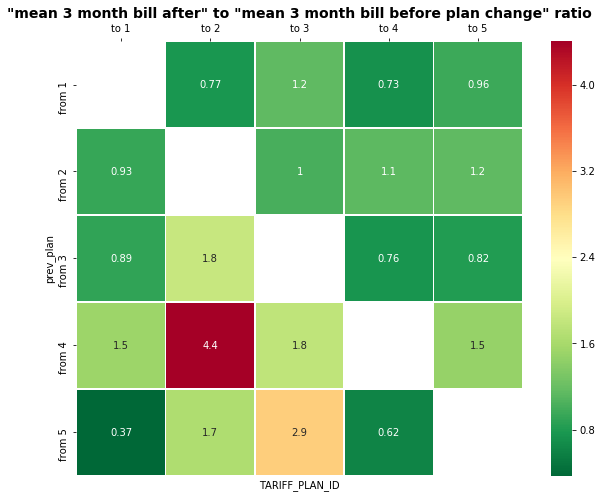

In [18]:
charge_changes = ps_chs.pivot_table(index='prev_plan', columns='TARIFF_PLAN_ID', values='change3', aggfunc=np.mean)
charge_changes.rename(columns=lambda col: 'to ' + str(col), inplace=True)
charge_changes.rename(index=lambda row: 'from ' + str(row) if row != -1 else 'no plan', inplace=True)
charge_changes_num_data = ps_with_chs.pivot_table(index='prev_plan', columns='TARIFF_PLAN_ID', values='change3', aggfunc=lambda s: (s > 0).sum())
before_unpayers = ps_with_chs.pivot_table(index='prev_plan', columns='TARIFF_PLAN_ID', values='was0', aggfunc=np.sum)
after_unpayers = ps_with_chs.pivot_table(index='prev_plan', columns='TARIFF_PLAN_ID', values='bec0', aggfunc=np.sum)
with pd.option_context('display.max_rows', 10):
    # display(charge_changes.style.background_gradient(cmap='summer'))
    display(charge_changes)
    print('charge_changes_num_data')
    display(charge_changes_num_data)
#     display(former_unpayers)
#     display(after_unpayers)
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('"mean 3 month bill after" to "mean 3 month bill before plan change" ratio',
             fontsize=14, fontweight="bold")
ax.xaxis.set_ticks_position('top')
# labels = np.array([[v if v > 0 else 0 for v in row] for row in charge_changes_num_data.values[1:]])
# print(labels)
sns.heatmap(charge_changes, cmap='RdYlGn_r', linewidths=0.5, annot=True, ax=ax, 
#             xticklabels=['to ' + str(col) for col in charge_changes],
#             yticklabels=['from ' + str(row) for row in charge_changes.index]
           )

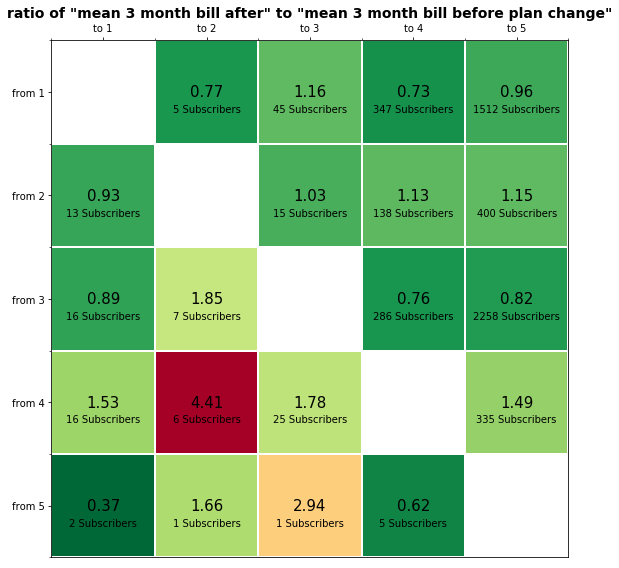

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(charge_changes.values, cmap='RdYlGn_r')

ax.set_xticks(np.arange(len(charge_changes.columns)))
ax.set_yticks(np.arange(len(charge_changes.index)))
ax.set_xticklabels(charge_changes.columns)
ax.set_yticklabels(charge_changes.index)
ax.set_xticks(np.arange(charge_changes.values.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(charge_changes.values.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.xaxis.set_ticks_position('top')
ax.set_title('ratio of "mean 3 month bill after" to "mean 3 month bill before plan change"',
             fontsize=14, fontweight="bold")

# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(charge_changes.index)):
    for j in range(len(charge_changes.columns)):
        text = ax.text(j, i, 
#                        '%.2f\n%.f Subscribers' % (charge_changes.values[i, j], charge_changes_num_data.values[1:][i, j]) if not np.isnan(charge_changes.values[i, j]) else '',
                       '\n\n\n%.f Subscribers' % (charge_changes_num_data.values[1:][i, j]) if not np.isnan(charge_changes.values[i, j]) else '',
                       ha="center", va="center", color="k", fontsize=10)
        text = ax.text(j, i, 
                       '%.2f' % (charge_changes.values[i, j]) if not np.isnan(charge_changes.values[i, j]) else '',
                       ha="center", va="center", color="k", fontsize=15)

fig.tight_layout()
plt.show()

# III SUSPENSIONS

## 1 Merge plan changes and suspensions data

In [46]:
period_months = 3
susps_min_start = suspensions['START_DT'].min()
susps_max_end = suspensions['END_DT'].max()
plans_max_end = ps['END_DTTM'].max()
ps2 = ps.iloc[:].copy()
ps2.loc[pd.isnull(ps2['END_DTTM']), 'END_DTTM'] = plans_max_end
ps_we_have_suspensions_data = ps2[((ps2['END_DTTM'] + pd.DateOffset(months=period_months)) > susps_min_start) & ((ps2['START_DTTM'] - pd.DateOffset(months=period_months)) < susps_max_end)]
plans_with_suspensions = pd.merge(ps_we_have_suspensions_data.iloc[:], suspensions.iloc[:], on=['SUBSCRIBER_ID'], how='left')
plans_with_suspensions.drop(inplace=True, columns=['duration_x', 'duration_y', 'STATUS', 'no_plan_duration', 'prev_duration'])

plans_with_suspensions['START_DTTM'] = plans_with_suspensions['START_DTTM'].dt.ceil('D')
plans_with_suspensions['END_DTTM'] = plans_with_suspensions['END_DTTM'].dt.floor('D')

print('period:', suspensions['START_DT'].min(), '..', suspensions['END_DT'].max())
with pd.option_context('display.max_rows', 5):
    display(ps2)
    display(suspensions.iloc[:])
    display(plans_with_suspensions)

period: 2016-06-01 00:00:00 .. 2018-01-17 00:00:00


plan_changes,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM,duration,prev_plan_row,prev_plan,prev_duration,no_plan_duration
0,1,2,2013-11-22 21:10:08,2017-03-11 14:24:17,1204 days 17:14:09,-1,-1,NaT,NaT
1,1,3,2017-03-11 14:24:18,2018-01-19 17:51:56,NaT,0,2,1204 days 17:14:09,00:00:01
...,...,...,...,...,...,...,...,...,...
12342,5989,5,2017-05-24 14:46:11,2017-05-25 20:12:32,1 days 05:26:21,-1,-1,NaT,NaT
12343,5989,1,2017-05-25 20:12:33,2018-01-19 17:51:56,NaT,12342,5,1 days 05:26:21,00:00:01


suspensions,SUBSCRIBER_ID,START_DT,END_DT,STATUS,duration
2961,5,2016-07-25,2016-08-14,Suspended,20 days
2914,5,2016-09-19,2016-09-28,Suspended,9 days
...,...,...,...,...,...
3342,5988,2017-09-08,2017-09-08,Suspended,0 days
3309,5988,2017-09-25,2017-10-08,Suspended,13 days


,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM,prev_plan_row,prev_plan,START_DT,END_DT
0,1,2,2013-11-23,2017-03-11,-1,-1,NaT,NaT
1,1,3,2017-03-12,2018-01-19,0,2,NaT,NaT
...,...,...,...,...,...,...,...,...
17924,5989,5,2017-05-25,2017-05-25,-1,-1,NaT,NaT
17925,5989,1,2017-05-26,2018-01-19,12342,5,NaT,NaT


## 2 Calculate duration of each suspension during the first and last 3 months

In [98]:
def calc_durs(plans_with_suspensions):
    invalid_plans_with_susps = plans_with_suspensions[(plans_with_suspensions['START_DTTM'] > plans_with_suspensions['END_DT']) | (plans_with_suspensions['END_DTTM'] < plans_with_suspensions['START_DT'])]
    p = plans_with_suspensions.iloc[:].copy()
#     p = p.drop(index=invalid_plans_with_susps.index)
    p = p[(p['START_DTTM'] + pd.DateOffset(months=period_months)) < p['END_DTTM']]
#     cross_plan_suspensions = p[(p['START_DTTM'] > p['START_DT']) | (p['END_DTTM'] < p['END_DT'])]
#     print('cross plan suspensions #:', len(cross_plan_suspensions))
    p['beg_end'] = p['START_DTTM'] + pd.DateOffset(months=period_months)
    p['end_start'] = p['END_DTTM'] - pd.DateOffset(months=period_months)
    p['s_days_beg'] = (p[['END_DT', 'beg_end']].min(axis=1) - p[['START_DT', 'START_DTTM']].max(axis=1) + pd.Timedelta(1, 'D')).dt.days.clip(0, np.inf)
    p['s_days_end'] = (p[['END_DT', 'END_DTTM']].min(axis=1) - p[['START_DT', 'end_start']].max(axis=1) + pd.Timedelta(1, 'D')).dt.days.clip(0, np.inf)
    p.loc[np.isnan(p['s_days_beg']), 's_days_beg'] = 0
    p.loc[np.isnan(p['s_days_end']), 's_days_end'] = 0
    p['s_num_beg'] = p['s_days_beg'] > 0
    p['s_num_end'] = p['s_days_end'] > 0
#     print(p[['END_DT', 'beg_end']].min(axis=1).iloc[4:7])
#     print(p['START_DT'].iloc[4:7])
#     print((p[['END_DT', 'beg_end']].min(axis=1) - p['START_DT']).iloc[4:7])
    return p

plans_with_susps = calc_durs(plans_with_suspensions)
with pd.option_context('display.max_rows', 10):
    display(plans_with_susps.describe())
    display(plans_with_susps)
#     print((plans_with_susps['END_DT'] - plans_with_susps['START_DT']).iloc[4:7])

,SUBSCRIBER_ID,TARIFF_PLAN_ID,prev_plan_row,prev_plan,s_days_beg,s_days_end
count,17069.000000,17069.000000,17069.000000,17069.000000,17069.000000,17069.000000
mean,3126.595055,3.534478,3332.399203,0.794716,50.169078,51.041479
std,1792.423483,1.476616,4182.252808,1.924377,45.501407,45.274866
min,1.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,1618.000000,3.000000,-1.000000,-1.000000,0.000000,0.000000
50%,3141.000000,4.000000,373.000000,1.000000,90.000000,91.000000
75%,4798.000000,5.000000,6721.000000,3.000000,93.000000,93.000000
max,5989.000000,5.000000,12342.000000,5.000000,93.000000,93.000000


,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM,prev_plan_row,prev_plan,START_DT,END_DT,beg_end,end_start,s_days_beg,s_days_end,s_num_beg,s_num_end
0,1,2,2013-11-23,2017-03-11,-1,-1,NaT,NaT,2014-02-23,2016-12-11,93.0,91.0,True,True
1,1,3,2017-03-12,2018-01-19,0,2,NaT,NaT,2017-06-12,2017-10-19,93.0,93.0,True,True
2,2,1,2016-02-06,2017-06-29,-1,-1,NaT,NaT,2016-05-06,2017-03-29,91.0,93.0,True,True
3,2,5,2017-06-30,2018-01-19,2,1,NaT,NaT,2017-09-30,2017-10-19,93.0,93.0,True,True
4,3,1,2015-05-07,2017-04-14,-1,-1,NaT,NaT,2015-08-07,2017-01-14,93.0,91.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17917,5987,3,2017-05-24,2018-01-19,12338,5,2017-07-09,2017-08-15,2017-08-24,2017-10-19,38.0,0.0,True,False
17921,5988,4,2017-05-23,2018-01-19,12340,1,2017-07-23,2017-07-23,2017-08-23,2017-10-19,1.0,0.0,True,False
17922,5988,4,2017-05-23,2018-01-19,12340,1,2017-09-08,2017-09-08,2017-08-23,2017-10-19,0.0,0.0,False,False
17923,5988,4,2017-05-23,2018-01-19,12340,1,2017-09-25,2017-10-08,2017-08-23,2017-10-19,0.0,0.0,False,False


## 3 calculate suspensions' durations and number of suspensions per plan

In [99]:
ps_with_susps = plans_with_susps.sort_values(by=['SUBSCRIBER_ID', 'TARIFF_PLAN_ID', 'START_DTTM'])
ps_with_susps = ps_with_susps.drop(columns=['START_DTTM', 'END_DTTM'])

ps_with_susps = ps_with_susps.groupby(by=['SUBSCRIBER_ID', 'TARIFF_PLAN_ID', 'prev_plan_row', 'prev_plan']).agg({
    's_days_beg': np.sum,
    's_days_end': np.sum,
    's_num_beg': np.sum,
    's_num_end': np.sum
})
ps_with_susps = ps_with_susps.reset_index(level=['SUBSCRIBER_ID', 'TARIFF_PLAN_ID', 'prev_plan_row', 'prev_plan'])
ps_with_susps = ps_with_susps.sort_values(by=['SUBSCRIBER_ID', 'prev_plan_row'])
ps_with_susps = ps_with_susps.drop(columns='prev_plan_row')

with pd.option_context('display.max_rows', 5):
    display(ps_with_susps)
    display(ps_with_susps[ps_with_susps['SUBSCRIBER_ID'] == 5919])

,SUBSCRIBER_ID,TARIFF_PLAN_ID,prev_plan,s_days_beg,s_days_end,s_num_beg,s_num_end
0,1,2,-1,93.0,91.0,1.0,1.0
1,1,3,2,93.0,93.0,1.0,1.0
...,...,...,...,...,...,...,...
11723,5988,4,1,1.0,0.0,1.0,0.0
11724,5989,1,5,93.0,93.0,1.0,1.0


,SUBSCRIBER_ID,TARIFF_PLAN_ID,prev_plan,s_days_beg,s_days_end,s_num_beg,s_num_end
11637,5919,4,-1,37.0,51.0,2.0,1.0
11636,5919,3,4,30.0,65.0,1.0,1.0


## 4 Add data about suspensions on the previous plan to each row

In [100]:
ps_susps = ps_with_susps.iloc[:].copy()
ps_susps = ps_susps.reset_index(drop=True)
ps_susps_shifted = pd.concat([ps_susps.iloc[-1:], ps_susps.iloc[0:-1]])
ps_susps_shifted = ps_susps_shifted.drop(columns=['TARIFF_PLAN_ID', 'prev_plan', 's_num_beg', 's_days_beg'])
ps_susps_shifted = ps_susps_shifted.rename(columns=lambda col: 'prev_' + col)
ps_susps_shifted = ps_susps_shifted.reset_index(drop=True)
ps_ss = pd.concat([ps_susps, ps_susps_shifted], axis=1)

nanify_cols = ['prev_s_days_end', 'prev_s_num_end']
ps_ss.loc[(ps_ss['prev_SUBSCRIBER_ID'] != ps_ss['SUBSCRIBER_ID']), nanify_cols] = np.nan
ps_ss = ps_ss.drop(columns=['prev_SUBSCRIBER_ID', 's_days_end', 's_num_end'])
ps_ss['s_num_change'] = ps_ss['s_num_beg'] / ps_ss['prev_s_num_end']
ps_ss['s_days_change'] = ps_ss['s_days_beg'] / ps_ss['prev_s_days_end']

ps_ss.loc[ps_ss['s_num_change'] == inf, 's_num_change'] = np.nan
ps_ss.loc[ps_ss['s_days_change'] == inf, 's_days_change'] = np.nan


with pd.option_context('display.max_rows', 10):
#     print(np.isnan(ps_ss['prev_s_days_end']).sum())
#     display(ps_ss.describe())
    display(ps_susps)    
    display(ps_susps_shifted)
    display(ps_ss)
    display(ps_ss[(ps_ss['prev_plan'] == -1) & (ps_ss['prev_s_days_end'] > 0)])
#     display(ps_ss[ps_ss['prev_plan']])

,SUBSCRIBER_ID,TARIFF_PLAN_ID,prev_plan,s_days_beg,s_days_end,s_num_beg,s_num_end
0,1,2,-1,93.0,91.0,1.0,1.0
1,1,3,2,93.0,93.0,1.0,1.0
2,2,1,-1,91.0,93.0,1.0,1.0
3,2,5,1,93.0,93.0,1.0,1.0
4,3,1,-1,93.0,91.0,1.0,1.0
...,...,...,...,...,...,...,...
11720,5985,5,4,3.0,0.0,2.0,0.0
11721,5986,1,5,93.0,93.0,1.0,1.0
11722,5987,3,5,58.0,0.0,2.0,0.0
11723,5988,4,1,1.0,0.0,1.0,0.0


,prev_SUBSCRIBER_ID,prev_s_days_end,prev_s_num_end
0,5989,93.0,1.0
1,1,91.0,1.0
2,1,93.0,1.0
3,2,93.0,1.0
4,2,93.0,1.0
...,...,...,...
11720,5984,93.0,1.0
11721,5985,0.0,0.0
11722,5986,93.0,1.0
11723,5987,0.0,0.0


,SUBSCRIBER_ID,TARIFF_PLAN_ID,prev_plan,s_days_beg,s_num_beg,prev_s_days_end,prev_s_num_end,s_num_change,s_days_change
0,1,2,-1,93.0,1.0,NaN,NaN,NaN,NaN
1,1,3,2,93.0,1.0,91.0,1.0,1.0,1.021978
2,2,1,-1,91.0,1.0,NaN,NaN,NaN,NaN
3,2,5,1,93.0,1.0,93.0,1.0,1.0,1.000000
4,3,1,-1,93.0,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11720,5985,5,4,3.0,2.0,NaN,NaN,NaN,NaN
11721,5986,1,5,93.0,1.0,NaN,NaN,NaN,NaN
11722,5987,3,5,58.0,2.0,NaN,NaN,NaN,NaN
11723,5988,4,1,1.0,1.0,NaN,NaN,NaN,NaN


,SUBSCRIBER_ID,TARIFF_PLAN_ID,prev_plan,s_days_beg,s_num_beg,prev_s_days_end,prev_s_num_end,s_num_change,s_days_change


## 5 Summarize data for each plan pair

In [101]:
susps_days = ps_ss.pivot_table(index='prev_plan', columns='TARIFF_PLAN_ID', values=['prev_s_days_end', 's_days_beg'])
susps_days_diff = susps_days['s_days_beg'] - susps_days['prev_s_days_end']
susps_days_num_data = ps_ss.pivot_table(index='prev_plan', columns='TARIFF_PLAN_ID', values=['prev_s_days_end', 's_days_beg'], aggfunc=lambda s: s.count())
susps_num = ps_ss.pivot_table(index='prev_plan', columns='TARIFF_PLAN_ID', values=['prev_s_num_end', 's_num_beg'])
susps_num_changes = ps_ss.pivot_table(index='prev_plan', columns='TARIFF_PLAN_ID', values='s_num_change')
susps_num_changes_num_data = ps_ss.pivot_table(index='prev_plan', columns='TARIFF_PLAN_ID', values='s_num_change', aggfunc=lambda s: s.count())

with pd.option_context('display.max_rows', 10): 
    display(susps_days)
    display(susps_days_diff)
    display(susps_num)
    
    print('datapoints number:')
    display(susps_days_num_data)

#     print('suspensions number change:')
#     display(susps_num_changes)
#     print('suspensions number change datapoints:')
#     display(susps_num_changes_num_data)

prev_s_days_end                                              \
TARIFF_PLAN_ID               1          2          3          4          5   
prev_plan                                                                    
-1                         NaN        NaN        NaN        NaN        NaN   
 1                         NaN  56.800000  84.978261  68.259887  78.015564   
 2                   63.846154        NaN  79.666667  66.986111  82.421836   
 3                   83.470588  83.111111        NaN  58.980456  76.265359   
 4                   65.227273  61.636364  56.916667        NaN  60.486874   
 5                   75.250000  91.333333  81.515152  63.142857        NaN   

               s_days_beg                                              
TARIFF_PLAN_ID          1          2          3          4          5  
prev_plan                                                              
-1              74.581325  78.218121  72.734664  57.700495  61.333333  
 1                    NaN  54.400000  84.937500  64.835655  77.796556  
 2              65.307692        NaN  76.062500  69.611111  83.070905  
 3              81.444444  70.888889        NaN  53.665625  75.682759  
 4              65.060606  67.350000  59.895833        NaN  60.285156  
 5              72.970149  92.250000  75.423729  65.232558        NaN

TARIFF_PLAN_ID,1,2,3,4,5
prev_plan,,,,,
-1,NaN,NaN,NaN,NaN,NaN
1,NaN,-2.400000,-0.040761,-3.424232,-0.219008
2,1.461538,NaN,-3.604167,2.625000,0.649068
3,-2.026144,-12.222222,NaN,-5.314831,-0.582601
4,-0.166667,5.713636,2.979167,NaN,-0.201717
5,-2.279851,0.916667,-6.091423,2.089701,NaN


prev_s_num_end                                          \
TARIFF_PLAN_ID              1         2         3         4         5   
prev_plan                                                               
-1                        NaN       NaN       NaN       NaN       NaN   
 1                        NaN  1.000000  1.000000  0.918079  0.955901   
 2                   0.769231       NaN  0.933333  0.784722  0.920596   
 3                   0.941176  1.777778       NaN  0.970684  0.964706   
 4                   0.863636  0.727273  0.916667       NaN  0.902148   
 5                   0.840909  1.000000  1.030303  0.809524       NaN   

               s_num_beg                                          
TARIFF_PLAN_ID         1         2         3         4         5  
prev_plan                                                         
-1              0.816767  0.847315  0.814486  0.910891  0.666667  
 1                   NaN  0.600000  0.937500  0.818942  0.908163  
 2              1.000000       NaN  0.937500  0.937500  0.955990  
 3              1.000000  0.777778       NaN  0.781250  0.880172  
 4              0.939394  0.800000  0.875000       NaN  0.824219  
 5              0.910448  1.000000  1.135593  0.860465       NaN

datapoints number:


prev_s_days_end                            s_days_beg         \
TARIFF_PLAN_ID               1     2     3      4       5          1      2   
prev_plan                                                                     
-1                         0.0   0.0   0.0    0.0     0.0     1992.0  596.0   
 1                         NaN   5.0  46.0  354.0  1542.0        NaN    5.0   
 2                        13.0   NaN  15.0  144.0   403.0       13.0    NaN   
 3                        17.0   9.0   NaN  307.0  2295.0       18.0    9.0   
 4                        22.0  11.0  36.0    NaN   419.0       33.0   20.0   
 5                        44.0   3.0  33.0   21.0     NaN       67.0    4.0   

                                       
TARIFF_PLAN_ID       3      4       5  
prev_plan                              
-1              2706.0  404.0    12.0  
 1                48.0  359.0  1568.0  
 2                16.0  144.0   409.0  
 3                 NaN  320.0  2320.0  
 4                48.0    NaN   512.0  
 5                59.0   43.0     NaN

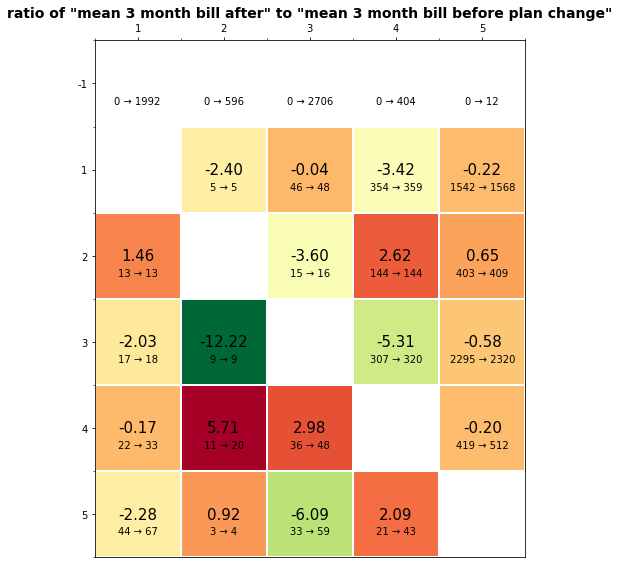

In [102]:
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(susps_days_diff.values, cmap='RdYlGn_r')

ax.set_xticks(np.arange(len(susps_days_diff.columns)))
ax.set_yticks(np.arange(len(susps_days_diff.index)))
ax.set_xticklabels(susps_days_diff.columns)
ax.set_yticklabels(susps_days_diff.index)
ax.set_xticks(np.arange(susps_days_diff.values.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(susps_days_diff.values.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.xaxis.set_ticks_position('top')
ax.set_title('ratio of "mean 3 month bill after" to "mean 3 month bill before plan change"',
             fontsize=14, fontweight="bold")

# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(susps_days_diff.index)):
    for j in range(len(susps_days_diff.columns)):
        text = ax.text(j, i, 
#                        '%.2f\n%.f Subscribers' % (charge_changes.values[i, j], charge_changes_num_data.values[1:][i, j]) if not np.isnan(charge_changes.values[i, j]) else '',
                       '\n\n\n%.f → %.f' % (susps_days_num_data['prev_s_days_end'].values[i, j], susps_days_num_data['s_days_beg'].values[i, j]) if not np.isnan(susps_days_num_data.values[i, j]) else '',
                       ha="center", va="center", color="k", fontsize=10)
        text = ax.text(j, i, 
                       '%.2f' % (susps_days_diff.values[i, j]) if not np.isnan(susps_days_diff.values[i, j]) else '',
                       ha="center", va="center", color="k", fontsize=15)

fig.tight_layout()
plt.show()